# Supervised methods
Since we now have labeled data, we can try some supervised methods. Our stakeholders are looking for a model with recall of at least 70% and precision of at least 85%.

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3

with sqlite3.connect('logs/logs.db') as conn:
    logs_2018 = pd.read_sql(
        'SELECT * FROM logs WHERE datetime BETWEEN "2018-01-01" AND "2019-01-01";', 
        conn, parse_dates=['datetime'], index_col='datetime'
    )
    hackers_2018 = pd.read_sql(
        'SELECT * FROM attacks WHERE start BETWEEN "2018-01-01" AND "2019-01-01";', 
        conn, parse_dates=['start', 'end']
    ).assign(
        duration=lambda x: x.end - x.start, 
        start_floor=lambda x: x.start.dt.floor('min'),
        end_ceil=lambda x: x.end.dt.ceil('min')
    )

## Get training and testing sets

In [2]:
def get_X(log, day):
    """
    Get data we can use for the X
    
    Parameters:
        - log: The logs dataframe
        - day: A day or single value we can use as a datetime index slice
    
    Returns: 
        A `pandas.DataFrame` object
    """
    return pd.get_dummies(log.loc[day].assign(
        failures=lambda x: 1 - x.success
    ).query('failures > 0').resample('1min').agg(
        {'username': 'nunique', 'failures': 'sum'}
    ).dropna().rename(
        columns={'username': 'usernames_with_failures'}
    ).assign(
        day_of_week=lambda x: x.index.dayofweek, 
        hour=lambda x: x.index.hour
    ).drop(columns=['failures']), columns=['day_of_week', 'hour'])

def get_y(datetimes, hackers, resolution='1min'):
    """
    Get data we can use for the y (whether or not a hacker attempted a log in during that time).
    
    Parameters:
        - datetimes: The datetimes to check for hackers
        - hackers: The dataframe indicating when the attacks started and stopped
        - resolution: The granularity of the datetime. Default is 1 minute.
        
    Returns:
        `pandas.Series` of Booleans.
    """
    date_ranges = hackers.apply(
        lambda x: pd.date_range(x.start_floor, x.end_ceil, freq=resolution), 
        axis=1
    )
    dates = pd.Series(dtype='object')
    for date_range in date_ranges:
        dates = pd.concat([dates, date_range.to_series()])
    return datetimes.isin(dates)

def get_X_y(log, day, hackers):
    """
    Get the X, y data to build a model with.
    
    Parameters:
        - log: The logs dataframe
        - day: A day or single value we can use as a datetime index slice
        - hackers: The dataframe indicating when the attacks started and stopped
        
    Returns:
        X, y tuple where X is a `pandas.DataFrame` object
        and y is a `pandas.Series` object
    """
    X = get_X(log, day)
    y = get_y(X.reset_index().datetime, hackers)
    return X, y

We will train on January 2018 and test on February 2018:

In [3]:
X_train, y_train = get_X_y(logs_2018, '2018-01', hackers_2018)
X_test, y_test = get_X_y(logs_2018, '2018-02', hackers_2018)

## Supervised anomaly detection
Now that we have our labeled data, let's use supervised learning algorithms to see if we can use this extra information to find the hackers. We will build two baseline models first:

- a dummy classifier that will predict labels based on the stratification in the data
- a Naive Bayes model that will predict the labels using Naive Bayes

### Baselining
#### Dummy classifier
This classifier will give us a model that is equivalent to the baseline we have been drawing on our ROC curves. The results will be poor on purpose. We will never use this classifier to actually make predictions&mdash;rather, we can use it to see if the models we are building are better than random guessing strategies. 

In [4]:
from sklearn.dummy import DummyClassifier # build a baseline

dummy_model = DummyClassifier(strategy='stratified', random_state=0).fit(X_train, y_train)
dummy_preds = dummy_model.predict(X_test)

##### Evaluation Partials
Create partials for less typing

In [5]:
# create partials for less typing
from functools import partial
from sklearn.metrics import classification_report
from ml_utils.classification import confusion_matrix_visual, plot_pr_curve, plot_roc

report = partial(classification_report, y_test)
roc = partial(plot_roc, y_test)
pr_curve = partial(plot_pr_curve, y_test)
conf_matrix = partial(confusion_matrix_visual, y_test, class_labels=[False, True])

No attackers are properly flagged with the dummy model. Notice how the ROC curve is diagonal and on top of the baseline we have seen in previous chapters. The precision-recall curve is also along its baseline at the percentage of attackers in the data. This means the dummy model is equivalent to random guessing:

Text(0.5, 0.98, 'Dummy Classifier with Stratified Strategy')

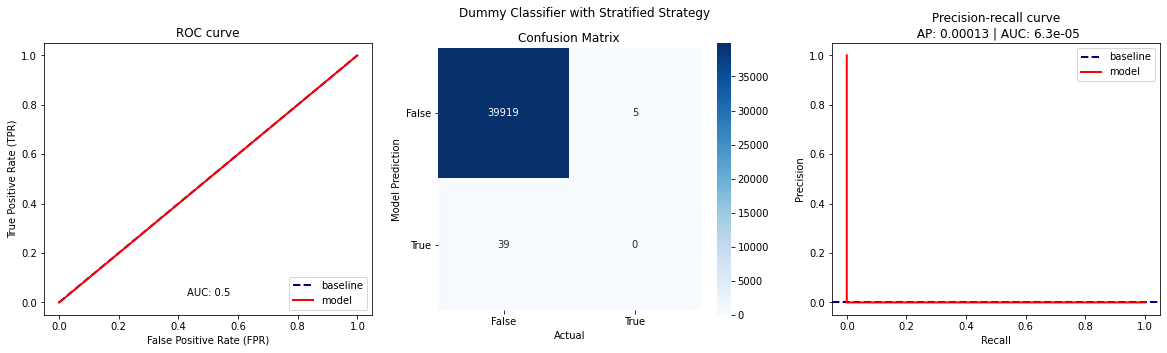

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
roc(dummy_model.predict_proba(X_test)[:,1], ax=axes[0])
conf_matrix(dummy_preds, ax=axes[1])
pr_curve(dummy_model.predict_proba(X_test)[:,1], ax=axes[2])
plt.suptitle('Dummy Classifier with Stratified Strategy')

The dummy classifier has 0 precision, recall, and $F_1$ score for the positive class (attacker):

In [7]:
print(report(dummy_preds))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     39958
        True       0.00      0.00      0.00         5

    accuracy                           1.00     39963
   macro avg       0.50      0.50      0.50     39963
weighted avg       1.00      1.00      1.00     39963



#### Naive Bayes
Naive Bayes makes a naive assumption of conditional independence of the features to simplify the use of Bayes theorem for modeling. It is very fast to train and a good baseline:

In [8]:
from sklearn.naive_bayes import GaussianNB # build another baseline with Naive Bayes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

nb_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('nb', GaussianNB())
]).fit(X_train, y_train)
nb_preds = nb_pipeline.predict(X_test)

The prior probabilities will be the percentage of each class in the data. 99.91% for valid users and 0.09% for attackers:

In [9]:
nb_pipeline.named_steps['nb'].class_prior_

array([9.99147160e-01, 8.52840182e-04])

This model correctly flags a few of the attackers, but it has a ton of false positives. Note that this is better than the dummy model:

Text(0.5, 0.98, 'Naive Bayes Classifier')

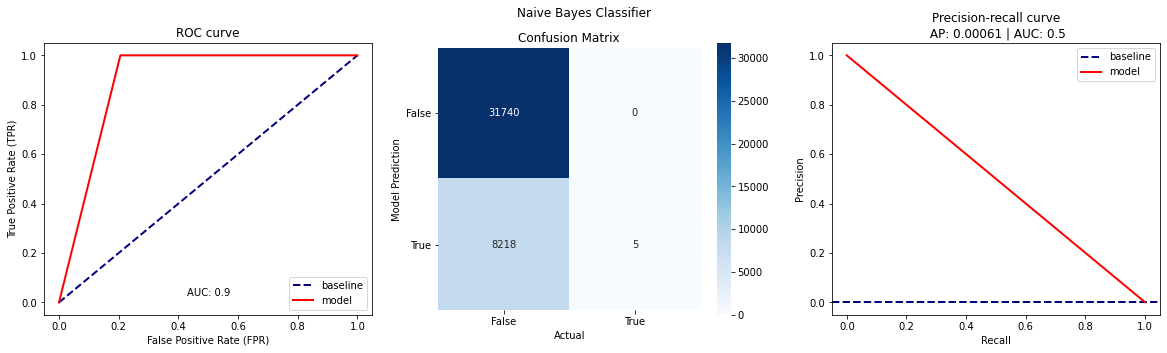

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
roc(nb_pipeline.predict_proba(X_test)[:,1], ax=axes[0])
conf_matrix(nb_preds, ax=axes[1])
pr_curve(nb_pipeline.predict_proba(X_test)[:,1], ax=axes[2])
plt.suptitle('Naive Bayes Classifier')

This is better than the dummy classifier, but it doesn't meet our stakeholders' requirements:

In [11]:
print(report(nb_preds))

              precision    recall  f1-score   support

       False       1.00      0.79      0.89     39958
        True       0.00      1.00      0.00         5

    accuracy                           0.79     39963
   macro avg       0.50      0.90      0.44     39963
weighted avg       1.00      0.79      0.89     39963



### Logistic Regression
We will be maximizing recall (averaged across the classes):

In [12]:
%%capture
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

lr_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('lr', LogisticRegression(random_state=0))
])

search_space = {
    'lr__C': [0.1, 0.5, 1, 2]
}

lr_grid = GridSearchCV(
    lr_pipeline, search_space, scoring='recall_macro', cv=5
).fit(X_train, y_train)

lr_preds = lr_grid.predict(X_test)

Say we knew how much our stakeholders valued recall over precision. We could then make a custom F-beta scorer to use with grid search. Here is a scorer that values recall 5 times more than precision:

In [13]:
from sklearn.metrics import make_scorer, fbeta_score
f_five = make_scorer(fbeta_score, beta=5) # pass as the `scoring` argument to grid search

The regularization selected from the grid search is the following:

In [14]:
lr_grid.best_params_

{'lr__C': 0.5}

This model had no false positives and is much better than the baselines. The ROC curve is much closer to the top-left corner, and the precision-recall is much closer to the top-right corner. Notice that the ROC curve is a bit more optimistic of the performance:

Text(0.5, 0.98, 'Logistic Regression Classifier')

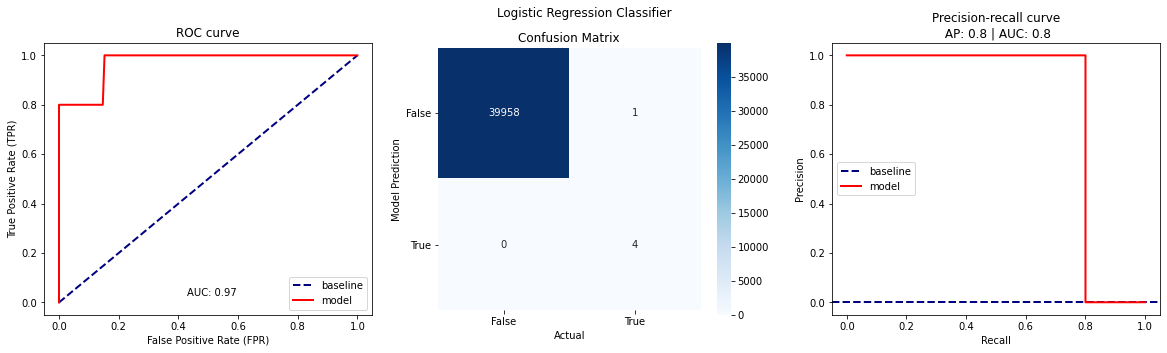

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
roc(lr_grid.predict_proba(X_test)[:,1], ax=axes[0])
conf_matrix(lr_preds, ax=axes[1])
pr_curve(lr_grid.predict_proba(X_test)[:,1], ax=axes[2])
plt.suptitle('Logistic Regression Classifier')

This model meets the requirements of the SOC. Our recall is at least 70% and precision is at least 85%:

In [16]:
print(report(lr_preds))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     39958
        True       1.00      0.80      0.89         5

    accuracy                           1.00     39963
   macro avg       1.00      0.90      0.94     39963
weighted avg       1.00      1.00      1.00     39963



However, there is a problem. We can't update this model with additional labeled data. It has to be trained from scratch to add data. We will see how to support this in the next notebook ([`5-online_learning.ipynb`](./5-online_learning.ipynb)).

<hr>
<div style="overflow: hidden; margin-bottom: 10px;">
    <div style="float: left;">
        <a href="./3-EDA_labeled_data.ipynb">
            <button>&#8592; Previous Notebook</button>
        </a>
    </div>
    <div style="float: right;">
        <a href="./5-online_learning.ipynb">
            <button>Next Notebook &#8594;</button>
        </a>
    </div>
</div>
<hr>